# Nazca Integration
This tutorial is about the integration of SolGen with Nazca. To run the provided example both the package SolGen and the sym branch of Nazca are needed. Note that the sym branch of nazca fails to be imported is solver is not found (this can be solved in the future). The sym branch basically provides the function to generate the solver object from the Nazca cell and implements the models for some of the cell provided by demofab (shallow straight, bend and 2x2 MMI). 

Note that all the examples here produced are quite simple, in particular do not have any non optical cell (for example, metal lines and pads). Probably it will not work if extra cells are added. This problem for now is left to future development. 


## Basic Usage

### Getting started, a simple straight waveguide. 
To start to explore the capability of the solver, let's start with the simplest example possible, the straight waveguide. A cell `strt` is created from the demofab pdk. Inside the pdk, the creator of the cell provides a `model_info` dictionary in the cell's attribute containing a model object from the GenSol package.

To create the solver object, the function `get_solver` is used. This takes as input a  Nazca cell and deliver the corresponding solver object. It is important that the cell to be processed has all the relevant pins at top level (in the case of the straight waveguide, pin 'a0' and 'b0') are directly provided by the pdk.

After the generation of the solver, the simulation is carried on in the same way as if the solver were generated manually.

nazca_logo
INFO: netlist.py: pin2pin drc: True
demo_awg


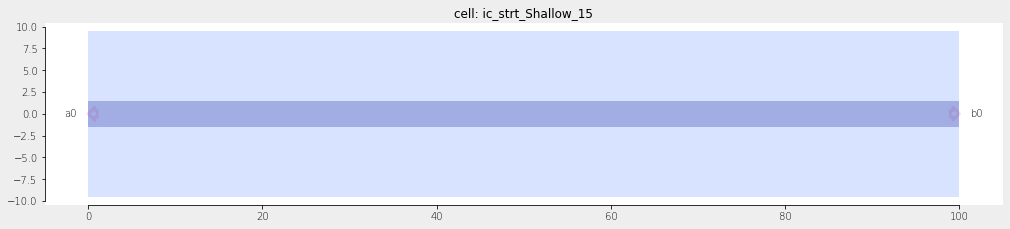

Transmission= 1.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

import nazca as nd
from nazca import demofab as demo
import solver as sv

strt=demo.shallow.strt(100.0)
nd.export_plt(topcells=strt)

sol=nd.get_solver(strt)
mod=sol.solve(wl=1.55)



print('Transmission=',mod.get_T('a0','b0'))

## Add-drop filter.
Following the same scheme of the GenSol introduction, let's move to a more complex example, the add-drop filter. Usually such a device is made using ring resonators. In this case, the MMI building block from the demofab pdk will be used as coupling element. Keep in mind that for now the model used for the MMI is quite simple, as it simply split the field 50/50, without any phase evolution or wavelength dependence. This may be easily changed by modifying the model object in `model_info` of the MMI cell. 

In this example, the add-drop cell is created by a function, in order to allow the easy creation of cells with different radii. It is important, for the correct operation of the simulator, the define top level pins for all the not connected pins inside the cell. 

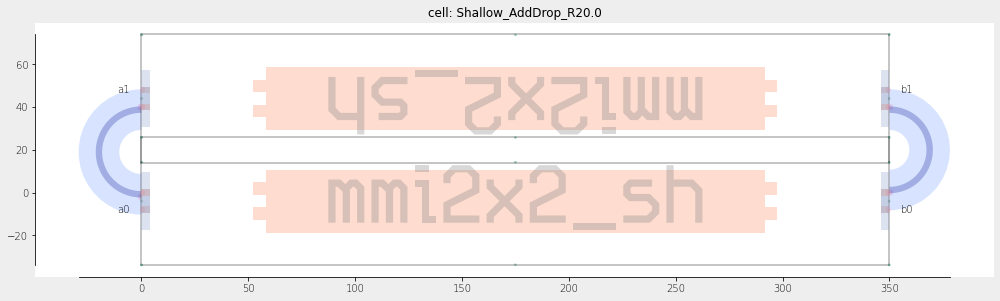

In [14]:
MMI=demo.mmi2x2_sh()

def add_drop(radius):
    with nd.Cell(name=f'Shallow_AddDrop_R{radius:.4}') as C:
        M1=MMI.put()
        demo.shallow.bend(angle=180.0,radius=radius).put()
        M2=MMI.put()    
        demo.shallow.bend(angle=180.0,radius=radius+1.0).put()
        nd.Pin('a0',pin=M1.pin['a1']).put()
        nd.Pin('a1',pin=M2.pin['b1']).put()
        nd.Pin('b0',pin=M1.pin['b1']).put()
        nd.Pin('b1',pin=M2.pin['a1']).put()
    return C
        
add_drop_1=add_drop(20.0)

nd.export_plt(topcells=add_drop_1)

After the cell creation, it can be processed with `get_solver`. The function runs though the iterator. For each cells with no model a solver object is created. Each solver object is then filled with the right structures and models, replicating the nazca hierarchy, and the solver object relative to the top cell is returned. After that, the simulation can be done in the conventional way.

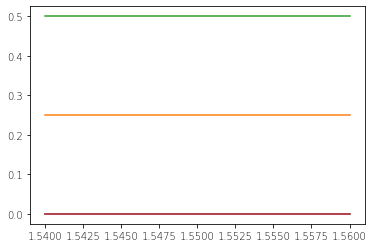

In [15]:
sol=nd.get_solver(add_drop_1)

wl_l=np.linspace(1.54,1.56,201)
res_l=[]
for wl in wl_l:
    mod=sol.solve(wl=wl)
    res_l.append((mod.get_T('a0','a0'),mod.get_T('a0','a1'),mod.get_T('a0','b0'),mod.get_T('a0','b1')))
                 
                 
plt.figure()
plt.plot(wl_l,[t[0] for t in res_l])
plt.plot(wl_l,[t[1] for t in res_l])
plt.plot(wl_l,[t[2] for t in res_l])
plt.plot(wl_l,[t[3] for t in res_l])

### Full hierarchy: the double ring filter
Off course, the newly create cell can be used in the making of other cells, as in the following, were two add-drops are combined to get a double ring filter. In this case, in order to get the transmission spectra of the double ring as well of the single ones, the function `get_solver` is called with the `fullreturn=True` option. This returns, instead of only the top cell solver, a dictionary with the solver of all the cells (the keys of the dictionary are the cell's `cnode` for now). In this way, by calling the solve on the different solvers, all the spectra can be obtained with one loop. 

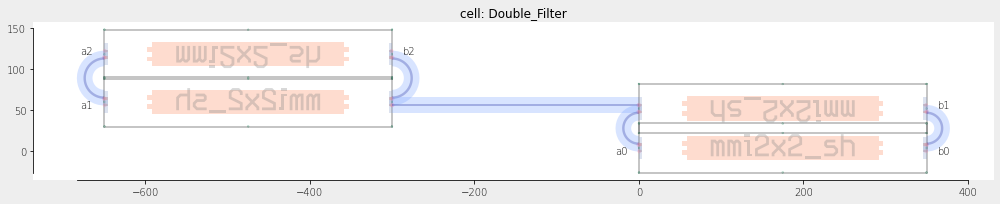

Structures and pins of solver:       Solver of Double_Filter (id=140224885777352))
Structure (id=140224885731224) containing Solver of Shallow_AddDrop_R20.0 (id=140224885731112)
Structure (id=140224885385816) containing Solver of ic_strt_Shallow_44 (id=140224885383520)
Structure (id=140224885383464) containing Solver of Shallow_AddDrop_R25.0 (id=140224885383800)

Connection of solver:       Solver of Double_Filter (id=140224885777352))
(Structure (id=140224885731224) containing Solver of Shallow_AddDrop_R20.0 (id=140224885731112),    a1) <--> (Structure (id=140224885385816) containing Solver of ic_strt_Shallow_44 (id=140224885383520),    a0)
(Structure (id=140224885385816) containing Solver of ic_strt_Shallow_44 (id=140224885383520),    b0) <--> (Structure (id=140224885383464) containing Solver of Shallow_AddDrop_R25.0 (id=140224885383800),    a0)

Free pins of solver:       Solver of Double_Filter (id=140224885777352))
(Structure (id=140224885731224) containing Solver of Shallow_AddDr

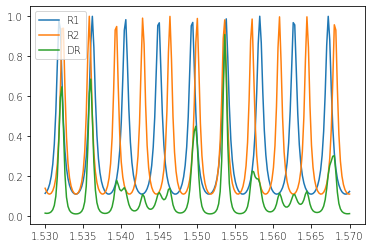

In [4]:
ad_R10=add_drop(20.0)
ad_R12=add_drop(25.0)

with nd.Cell(name='Double_Filter') as DF:
    r1=ad_R10.put()
    demo.shallow.strt(300.0).put(r1.pin['a1'])
    r2=ad_R12.put(flip=True)
    
    nd.Pin('a0',pin=r1.pin['a0']).put()
    nd.Pin('a1',pin=r2.pin['b0']).put()
    nd.Pin('a2',pin=r2.pin['b1']).put()
    nd.Pin('b0',pin=r1.pin['b0']).put()
    nd.Pin('b1',pin=r1.pin['b1']).put()
    nd.Pin('b2',pin=r2.pin['a1']).put()
    
    
nd.export_plt(topcells=DF)

sol=nd.get_solver(DF, fullreturn=True)

sol[DF.cnode].show_structures()
sol[DF.cnode].show_connections()
sol[DF.cnode].show_free_pins()




wl_l=np.linspace(1.53,1.57,201)
res_l=[]
for wl in wl_l:
    R1=sol[ad_R10.cnode].solve(wl=wl)
    R2=sol[ad_R12.cnode].solve(wl=wl)
    mod=sol[DF.cnode].solve(wl=wl)
    res_l.append((R1.get_T('a0','a1'),R2.get_T('a0','a1'),mod.get_T('a0','b2')))
                 
                 
plt.figure()
plt.plot(wl_l,[t[0] for t in res_l], label='R1')
plt.plot(wl_l,[t[1] for t in res_l], label='R2')
plt.plot(wl_l,[t[2] for t in res_l], label='DR')
plt.legend()

## More advanced features
### Model definition
Sometimes, the user would like to define a custom model for a nazca cell. This is done directly assign inserting a model object in the `model_info` dictionary of the cell. The interior of the cell can be drawn as usual, however will not have any consequence in the simulation, since all the information is taken from the model and interior of the cell is not analyzed. All the model's port need to have a pin in the cell with the same name. The cell can also have pins which are not in the model, and that will be ignored in the simulation. 

Below is an example of the definition of a thermal phase shifter, with optical pins for waveguides and electrical pins for the "heater".

The object to be inserted in the `model_info` dictionary can be either a model or a solver. In case of a solver, this can be conventionally built using standard GenSol sintax. 

In this case, to build the model of a thermal phase shifter (a normal waveguide plus a phase shifter) a trick is used. To get the right dispersion, the model of the waveguide is collected directly from nazca by calling `get_solver` on an interconnect cell. Be careful to use this trick if you want to use `get_solver` with not default parameters (in particular the `allowed` parameter).

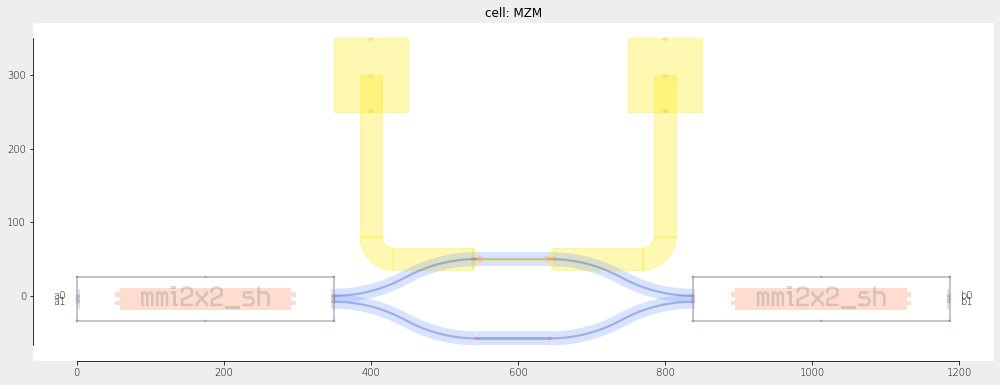

Text(0, 0.5, 'Transmission')

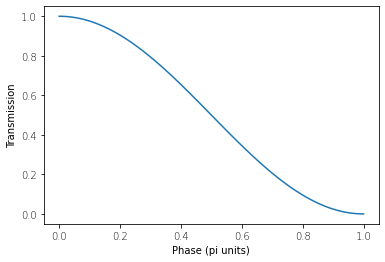

In [5]:
xsShallow=nd.get_xsection('Shallow')
with nd.Cell(name='PhaseShifter') as PS:
    t1=demo.metaldc.taper(width2=2.0,length=10.0).put()
    demo.metaldc.strt(90.0,width=2.0).put()
    t2=demo.metaldc.taper(width1=2.0,length=10.0).put()
    
    wg=demo.shallow.strt(100.0).put(5.0,0.0,0.0)
    
    nd.Pin('c0',pin=t1.pin['a0']).put()
    nd.Pin('c1',pin=t2.pin['b0']).put()
    nd.Pin('a0',pin=wg.pin['a0']).put()
    nd.Pin('b0',pin=wg.pin['b0']).put()
    
    with sv.Solver(name='THPS') as S:
        wg = nd.get_solver(demo.shallow.strt(100.0)).put()
        ps = sv.PhaseShifter().put('a0', wg.pin['b0'])
        sv.raise_pins()
    
    PS.model_info['model']=S
    
with nd.Cell(name='DC_pad') as DCp:
    demo.metaldc.strt(100.0,width=100.0).put(-50.0,0,0)
    nd.Pin('a0',xs=demo.metaldc.xs).put(0,0,90.0)
    
    
with nd.Cell(name='MZM') as MZM:
    m1=MMI.put()
    demo.shallow.sbend(offset=50.0).put()
    ps=PS.put()
    #demo.shallow.strt(100.0).put()
    demo.shallow.sbend(offset=-50.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-50.0).put(m1.pin['b1'])
    demo.shallow.strt(100.0).put()
    demo.shallow.sbend(offset=50.0).put()
    
    DCp.put(400.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c0']).put()
    DCp.put(800.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c1']).put()
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('a1',pin=m1.pin['a1']).put()
    nd.Pin('b0',pin=m2.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['b1']).put()
    
        
        
nd.export_plt(topcells=MZM)

sol=nd.get_solver(MZM)

sol.solve(wl=1.55)

psl=np.linspace(0.0,1.0,101)
T=[sol.solve(wl=1.55,PS=ps).get_T('a0','b0') for ps in psl]
plt.plot(psl,T)
plt.xlabel('Phase (pi units)')
plt.ylabel('Transmission')

### Multiple parameters
In the previous example, the parameter's name of the parametric block was fixed, and was the same for all instanced of the cell 'PS'. This severely limits the flexibility of the tool, since and arbitrary number of thermal phase shifter may be need in a design, and fine control an all of them is needed.


For this reason, an option for renaming the parameters inside a cell is added to the put statement. When placing an instance of a cell containing some parametric models, just pass a 'param_mapping' dictionary (mapping `{old_parameter_name : new_parameter_name}`) to the put statement. The parameter for that instance will be renamed according to the mapping. In this way, it is possible to assign to each instance of a parametric cell a unique parameter name, in order to finely control the simulation. 

Here is an example of the same MZM as before, but with  a phase shifter in each arm.

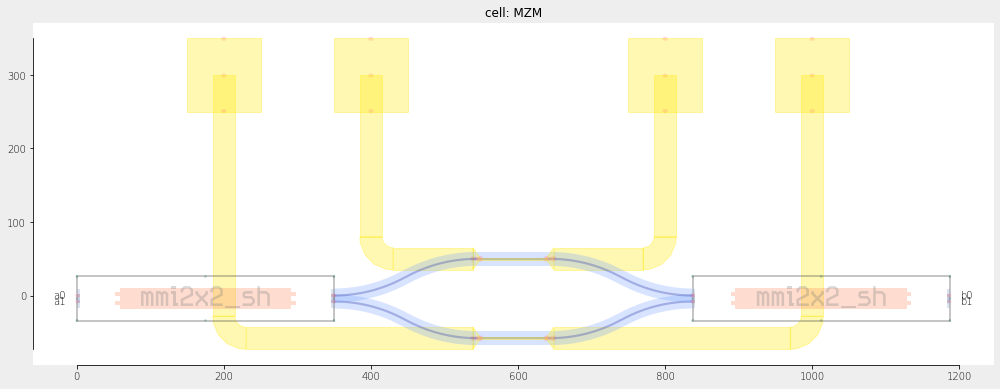

Text(0, 0.5, 'Transmission')

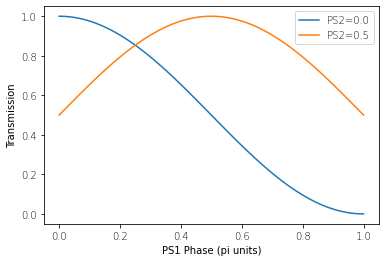

In [6]:
with nd.Cell(name='MZM') as MZM_bal:
    m1=MMI.put()
    demo.shallow.sbend(offset=50.0).put()
    ps=PS.put(param_mapping={'PS': 'PS1'})
    demo.shallow.sbend(offset=-50.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-50.0).put(m1.pin['b1'])
    ps2=PS.put(param_mapping={'PS': 'PS2'})
    demo.shallow.sbend(offset=50.0).put()
    
    DCp.put(400.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c0']).put()
    DCp.put(800.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps.pin['c1']).put()

    DCp.put(200.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c0']).put()
    DCp.put(1000.0,300.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(ps2.pin['c1']).put()
    
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('a1',pin=m1.pin['a1']).put()
    nd.Pin('b0',pin=m2.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['b1']).put()
    
nd.export_plt(topcells=MZM_bal)

sol=nd.get_solver(MZM_bal)


psl=np.linspace(0.0,1.0,101)
T1=[sol.solve(wl=1.55,PS1=ps).get_T('a0','b0') for ps in psl]
T2=[sol.solve(wl=1.55,PS1=ps,PS2=0.5).get_T('a0','b0') for ps in psl]

plt.plot(psl,T1, label='PS2=0.0')
plt.plot(psl,T2, label='PS2=0.5')
plt.legend()
plt.xlabel('PS1 Phase (pi units)')
plt.ylabel('Transmission')

As can be seen from the script, the phase in each arm can be set separately. In particular, the graph plots the transmission thought the MZM as a function of the pahse of the first arm for two different value of the phase in the second arm. 

### Multiple renaming and more complex circuits:
An important feature of the parameter renaming feature, is that it can be done at multiple levels and even on already mapped parameters. For example, we could use a 2 MZM similar to before (with a 'PS1' and a 'PS2' parameters already renamed) to build a more complex IQ modulator, renaming 'PS1' and 'PS2' of both MZM when we place them. This allow the building of complex circuit with the least amount of programming overhead, since once defined every parametric cell can be reused multiple times without losing control of the individual parameters.

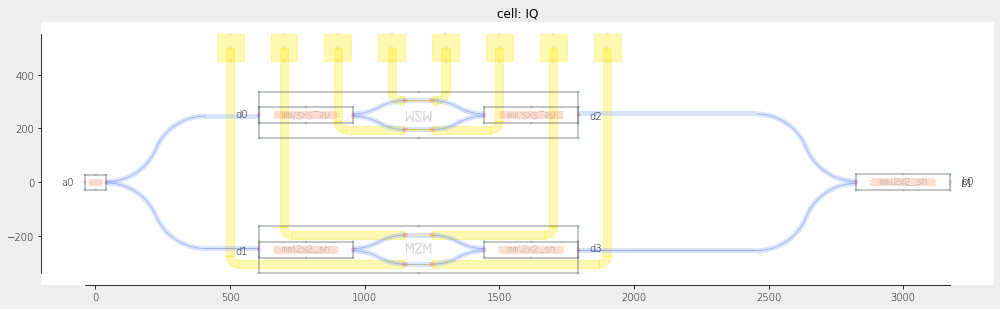

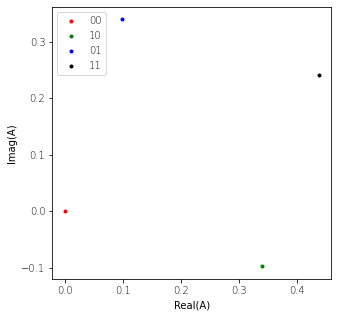

In [7]:
with nd.Cell(name='MZM', autobbox=True) as MZM_bal:
    m1=MMI.put()
    demo.shallow.sbend(offset=50.0).put()
    ps=PS.put(param_mapping={'PS': 'PS1'})
    demo.shallow.sbend(offset=-50.0).put()
    m2=MMI.put()
    demo.shallow.sbend(offset=-50.0).put(m1.pin['b1'])
    ps2=PS.put(param_mapping={'PS': 'PS2'})
    demo.shallow.sbend(offset=50.0).put()    
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('a1',pin=m1.pin['a1']).put()
    nd.Pin('b0',pin=m2.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['b1']).put()

    nd.Pin('c0',pin=ps.pin['c0']).put()
    nd.Pin('c1',pin=ps.pin['c1']).put()
    nd.Pin('c2',pin=ps2.pin['c0']).put()
    nd.Pin('c3',pin=ps2.pin['c1']).put()
    
    

MMI1x2=demo.mmi1x2_sh()
with nd.Cell(name='IQ') as IQ:
    m1=MMI1x2.put('cc',0,0,180)
    m2=MMI.put('cc',3000.0,0,180)
    mzm1=MZM_bal.put('cc',1200.0,250,180,flip=True,param_mapping={'PS1' : 'I1', 'PS2' : 'I2'})
    mzm2=MZM_bal.put('cc',1200.0,-250,180,param_mapping={'PS1' : 'Q1', 'PS2' : 'Q2'})
    
    demo.shallow.sbend_p2p(m1.pin['b0'],mzm1.pin['a0']).put()
    demo.shallow.sbend_p2p(m1.pin['b1'],mzm2.pin['a0']).put()
    demo.shallow.sbend_p2p(m2.pin['a0'],mzm1.pin['b1']).put()
    demo.shallow.sbend_p2p(m2.pin['a1'],mzm2.pin['b1']).put()
    
    nd.Pin('a0',pin=m1.pin['a0']).put()
    nd.Pin('b0',pin=m2.pin['b0']).put()
    nd.Pin('b1',pin=m2.pin['b1']).put()

    nd.Pin('d0',pin=mzm1.pin['a1']).put()
    nd.Pin('d1',pin=mzm2.pin['a1']).put()
    nd.Pin('d2',pin=mzm1.pin['b0']).put()
    nd.Pin('d3',pin=mzm2.pin['b0']).put()
    

    DCp.put(500.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c2']).put()
    DCp.put(700.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c0']).put()
    DCp.put(900.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c0']).put()
    DCp.put(1100.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c2']).put()
    DCp.put(1300.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c3']).put()
    DCp.put(1500.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm1.pin['c1']).put()
    DCp.put(1700.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c1']).put()
    DCp.put(1900.0,500.0,180.0)
    demo.metaldc.strt_bend_strt_p2p(mzm2.pin['c3']).put()

    
nd.export_plt(topcells=IQ)
IQ_sol=nd.get_solver(IQ)


plt.figure(figsize=[5.0,5.0])
A=IQ_sol.solve(wl=1.55,I1=0.0,I2=0.0,Q1=0.0,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.r', label='00')
A=IQ_sol.solve(wl=1.55,I1=0.5,I2=0.0,Q1=0.0,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.g', label='10')
A=IQ_sol.solve(wl=1.55,I1=0.0,I2=0.0,Q1=0.5,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.b', label='01')
A=IQ_sol.solve(wl=1.55,I1=0.5,I2=0.0,Q1=0.5,Q2=0.0).get_A('a0','b0')
plt.plot(A.real,A.imag,'.k', label='11')
plt.xlabel('Real(A)')
plt.ylabel('Imag(A)')
plt.legend()




In the graph it is reported the complex amplitude (real and imaginary) of the output of the IQ modulator. The four point corresponds to both modulators being off (00), one off and one on (01 and 10) and both on (11). As can be seen, the output us what is is expected by an IQ modulator. 

### Combining different models and managing complex in/out
In this section we will built a coherent receiver for the already proposed IQ modulator, and we will use the two solvers together to simulate a full transmission line. Lets start first by building the receiver:

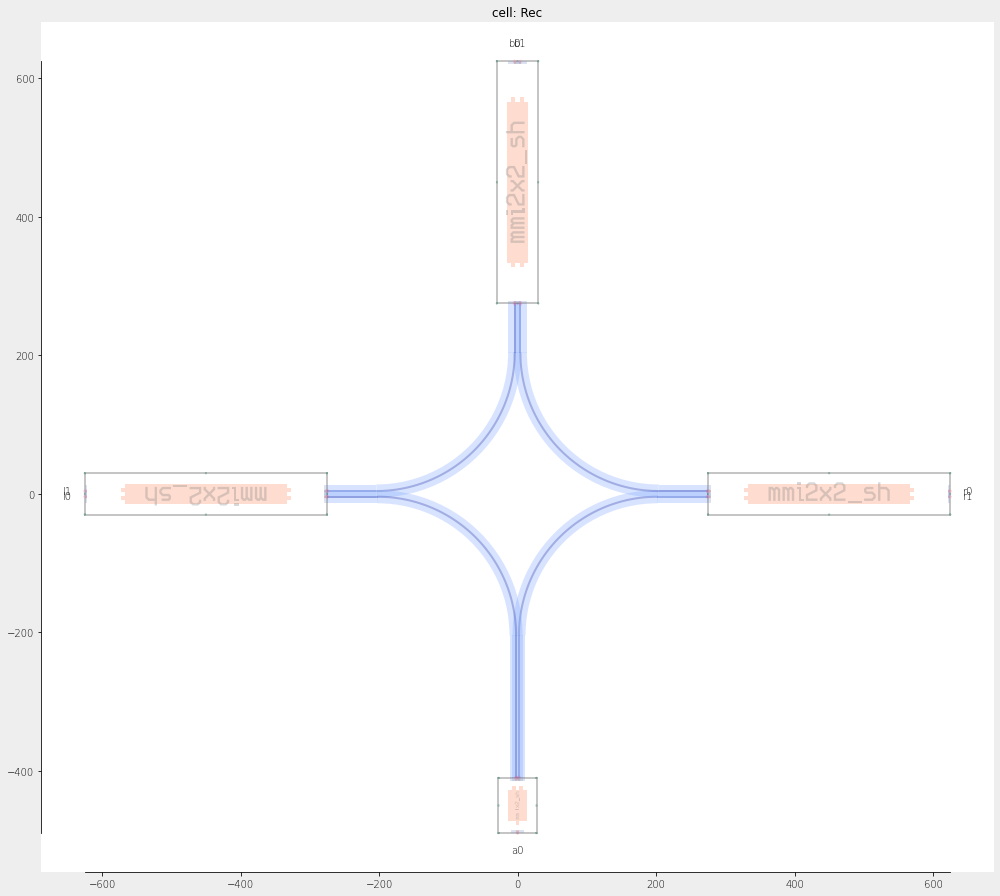

In [8]:
with nd.Cell(name='Rec') as Rec:
    mb=MMI1x2.put('cc',0,-450.0,270)
    mt=MMI.put('cc',0,450.0,270)
    
    ml=MMI.put('cc',-450.0,0.0,0.0)
    mr=MMI.put('cc',450.0,0.0,180)

    demo.shallow.strt_bend_strt_p2p(mb.pin['b0'],ml.pin['a0']).put()
    demo.shallow.strt_bend_strt_p2p(ml.pin['a1'],mt.pin['a0']).put()
    demo.shallow.strt_bend_strt_p2p(mt.pin['a1'],mr.pin['a0']).put()
    demo.shallow.strt_bend_strt_p2p(mr.pin['a1'],mb.pin['b1']).put()

    
    
    nd.Pin('a0',pin=mb.pin['a0']).put()
    nd.Pin('b0',pin=mt.pin['b0']).put()
    nd.Pin('b1',pin=mt.pin['b1']).put()

    nd.Pin('l0',pin=ml.pin['b0']).put()
    nd.Pin('l1',pin=ml.pin['b1']).put()
    nd.Pin('r0',pin=mr.pin['b0']).put()
    nd.Pin('r1',pin=mr.pin['b1']).put()

    
nd.export_plt(topcells=Rec)

In order to extract both the amplitude and phase information from the incoming signal, the receiver is a quite complex device. In this configuration it involves 7 ports: 3 inputs and 4 outputs. 

The input in the 1x2 MMI (pin 'a0') is used as input for the local oscillator (a local laser providing phase reference). The signal is fed to one of the port of the opposite 2x2 MMI (either pin 'b0' or 'b1'). The third input in this case is not used. 

The intensity of radiation at all 4 output is monitored, and the meaningful data are the difference in intensity between the ports of the same MMI (basically, 'l0'-'l1' and 'r0'-'r1')

In the following simulation, the local oscillator will provide a reference with complex amplitude of '1.0', while as signal the output from the IQ modulator will be used. Since more than one input is provided to the receiver, the function 'get_A' is not enough to obtain the requested information. In his place, the function `get_output`, will be used. This function takes as input a dictionary of the complex amplitudes at each pin (missing pins assume 0 amplitude) and returns a dictionary with the amplitudes at the outputs. 

Text(0, 0.5, 'r0-r1')

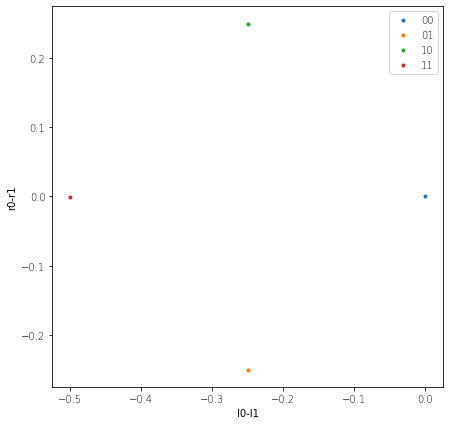

In [9]:
rec_sol=nd.get_solver(Rec)

plt.figure(figsize=[7.0,7.0])
for i in [0,1]:
    for j in [0,1]:
        sig=IQ_sol.solve(wl=1.55,I1=0.5*i,I2=0.0,Q1=0.5*j,Q2=0.0).get_A('a0','b0')
        rec_mod=rec_sol.solve(wl=1.55)
        out=rec_mod.get_output({'a0':1.0,'b0':sig})
        plt.plot(out['l0']-out['l1'],out['r0']-out['r1'],'.', label=f'{i}{j}')
plt.legend()
plt.xlabel('l0-l1')
plt.ylabel('r0-r1')